# Dependencies

In [1]:
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pandas Config
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Seaborn Theme 
sns.set_theme(style = "white")

# Useful Functions

In [2]:
def get_summary(df: pd.DataFrame, pred: bool = False) -> pd.DataFrame: 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()]).squeeze(axis = 0)
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew(numeric_only = True)
    kurtosis = df.kurtosis(numeric_only = True)
    
    print('Data shape:', df.shape)
    
    if ~pred:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        df_summary = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort = True)

    else:
        corr = df.corr()[pred]
        df_summary = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort = True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    df_summary.columns = cols
    
    return df_summary

def plot_missing_values(df: pd.DataFrame):
    # Missing Values Percentage
    missing_values = df.isna().mean().sort_values(ascending = False)
    missing_values = missing_values[missing_values > 0]*100

    # Plot Missing Values
    plt.figure(figsize = (10, 7)) 
    missing_values.plot.bar(fontsize = 15, color = "c", alpha = 0.9)
    plt.title("Porcentaje de Valores Faltantes", fontsize = 20)
    plt.legend()
    plt.show()
    
def tidy_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # Get Numpy Array
    array = df.values.copy()
    n_variables = array.shape[0]
    variables_names = df.columns

    # Get Indices of Lower Triangule Matrix
    iu2 = np.triu_indices(n_variables)

    # Drop Upper Triangule Matrix
    array[iu2] = 9999
    corr_mat = pd.DataFrame(array, index = variables_names, columns = variables_names)
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.query("r != 9999")
    
    # Abs of Correlation
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return corr_mat.reset_index(drop = True)

# Esta función verifica si las listas con los tipos de datos coinciden con los nombres de las columnas
# Además verifica si no se repitieron las columnas en dos tipos o más de datos
def very_amount_columns(list_columns:list, list_lists_types: list) -> bool:
    # Check if the amount of columns is the same
    amount_type = 0
    list_types = []
    for list_type in list_lists_types:
        amount_type += len(list_type)
        list_types += list_type
    same_amount_columns = len(list_columns) == amount_type

    # Check if the names of columns is the same
    same_name_columns = set(list_types) == set(list_columns)
    
    if same_amount_columns & same_name_columns:
        return True
    else:
        if not same_amount_columns:
            print("La cantidad de columnas no coincide")
        if not same_name_columns:
            print("Los nombres de las columnas no coincide")
        return False

# Global Variables

In [3]:
RANDOM_STATE = 12354
SAMPLE_FRAC = 0.1

# Read Data

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information
1. `id`: unique identifier
2. `gender`: "Male", "Female" or "Other"
3. `age`: age of the patient
4. `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. `ever_married`: "No" or "Yes"
7. `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. `Residence_type`: "Rural" or "Urban"
9. `avg_glucose_level`: average glucose level in blood
10. `bmi`: body mass index
11. `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. `stroke`: 1 if the patient had a stroke or 0 if not
**Note:** "Unknown" in `smoking_status` means that the information is unavailable for this patient

Source: [Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?datasetId=1120859&sortBy=voteCount)

**Stroke:**  Damage to the brain from interruption of its blood supply. A stroke is a medical emergency. Symptoms of stroke include trouble walking, speaking and understanding, as well as paralysis or numbness of the face, arm or leg.

Source: [Stroke-Symptoms and causes](https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113)

In [4]:
# Paths
root = os.getcwd()
data_folder_path = os.path.join("data")

data_file_path = os.path.join(data_folder_path, "healthcare-dataset-stroke-data.csv")

In [5]:
# Read Data
data = pd.read_csv(data_file_path)

In [6]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Quick EDA

In [7]:
get_summary(data)

Data shape: (5110, 12)


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Residence_type,object,5110,2,0,0.000000,"[Urban, Rural]",NaN,NaN
age,float64,5110,104,0,0.000000,"[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69.0, 59.0, 78.0, 54.0, 50.0, 64.0, 75.0, 60.0, 57.0,...",-0.137059,-0.991010
avg_glucose_level,float64,5110,3979,0,0.000000,"[228.69, 202.21, 105.92, 171.23, 174.12, 186.21, 70.09, 94.39, 76.15, 58.57, 80.43, 120.46, 104....",1.572284,1.680479
bmi,float64,4909,419,201,3.933464,"[36.6, nan, 32.5, 34.4, 24.0, 29.0, 27.4, 22.8, 24.2, 29.7, 36.8, 27.3, 28.2, 30.9, 37.5, 25.8, ...",1.055340,3.362659
ever_married,object,5110,2,0,0.000000,"[Yes, No]",NaN,NaN
gender,object,5110,3,0,0.000000,"[Male, Female, Other]",NaN,NaN
heart_disease,int64,5110,2,0,0.000000,"[1, 0]",3.947244,13.586052
hypertension,int64,5110,2,0,0.000000,"[0, 1]",2.715392,5.375456
id,int64,5110,5110,0,0.000000,"[9046, 51676, 31112, 60182, 1665, 56669, 53882, 10434, 27419, 60491, 12109, 12095, 12175, 8213, ...",-0.019913,-1.212368
smoking_status,object,5110,4,0,0.000000,"[formerly smoked, never smoked, smokes, Unknown]",NaN,NaN


# EDA

## Data Types

In [12]:
cuantitative_columns = ['age',
                       'avg_glucose_level',
                       'bmi']

cualitative_columns = ['Residence_type',
 'ever_married',
 'gender',
 'heart_disease',
 'hypertension',
 'smoking_status',
 'stroke',
 'work_type']

date_columns = []

code_columns = ["id"]

text_columns = []

columns_types_list = [cuantitative_columns, cualitative_columns, date_columns, code_columns, text_columns]

In [13]:
# To Avoid  Error Prone While writing Column Types
very_amount_columns(data.columns.tolist(), columns_types_list)

True

In [14]:
columns_types_list_num = [len(c) for c in columns_types_list]
columns_types_list_names = ["Cuantitativos", "Cualitativos", "Fechas", "Códigos", "Textos"]

In [16]:
# Tipos de Datos
tipos_datos_df = pd.DataFrame({"Tipos de Datos": columns_types_list_names,
                               "Número de Columnas": columns_types_list_num})
tipos_datos_df.sort_values("Número de Columnas", ascending = False)

,Tipos de Datos,Número de Columnas
1,Cualitativos,8
0,Cuantitativos,3
3,Códigos,1
2,Fechas,0
4,Textos,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [18]:
data[cualitative_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Residence_type  5110 non-null   object
 1   ever_married    5110 non-null   object
 2   gender          5110 non-null   object
 3   heart_disease   5110 non-null   int64 
 4   hypertension    5110 non-null   int64 
 5   smoking_status  5110 non-null   object
 6   stroke          5110 non-null   int64 
 7   work_type       5110 non-null   object
dtypes: int64(3), object(5)
memory usage: 319.5+ KB


In [19]:
data[cuantitative_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5110 non-null   float64
 1   avg_glucose_level  5110 non-null   float64
 2   bmi                4909 non-null   float64
dtypes: float64(3)
memory usage: 119.9 KB


## Data Dimention

In [21]:
data.shape

(5110, 12)

## Duplicated Rows

In [22]:
data.duplicated().sum()

0

## Distribution of Cuantitative Variables

In [23]:
for col in cuantitative_columns:
    n_zero_values = (data[col] == 0).sum()
    n_negative_values = (data[col] < 0).sum()
    if n_zero_values > 0:
        print(f"The variable {col} has {n_zero_values} cero values.")
    if n_negative_values > 0:
        print(f"The variable {col} has {n_negative_values} cero values.")

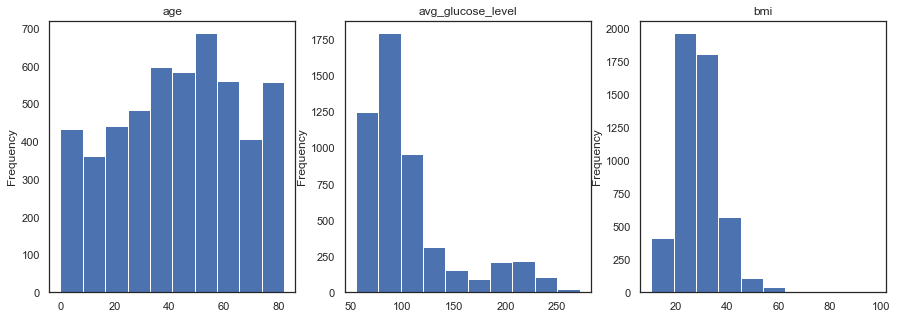

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes = axes.flat
for i, col in enumerate(cuantitative_columns):
    data[col].plot.hist(title = col, ax = axes[i])
plt.show()

## Distribution of Cuantitative Variables

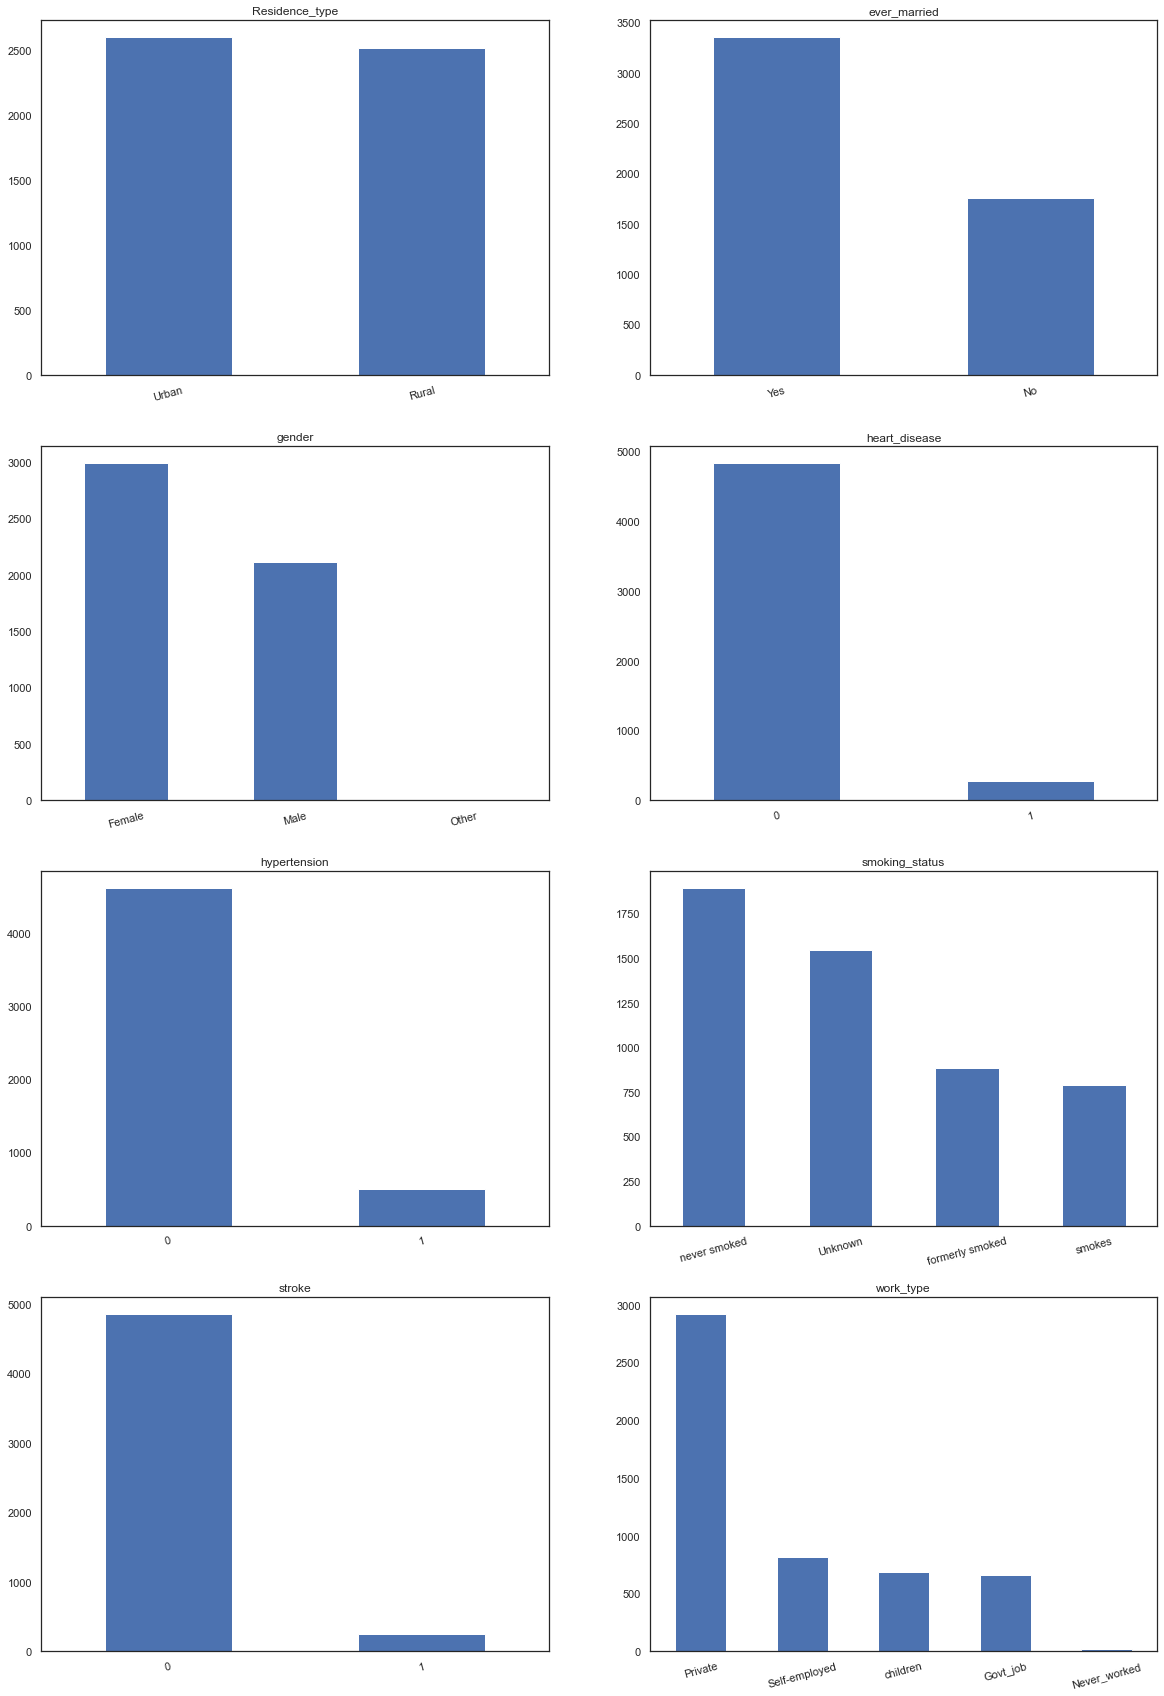

In [37]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 30))
axes = axes.flat
for i, col in enumerate(cualitative_columns):
    data[col].value_counts().plot.bar(title = col, ax = axes[i], rot = 15)
plt.show()

## Missing Values

In [38]:
# Columns with Missing Values
(data.isna().sum() > 0).sum()

1

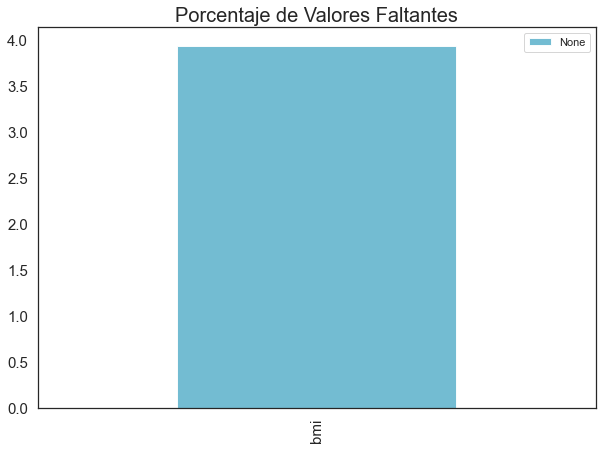

In [39]:
plot_missing_values(data)

## Outliers

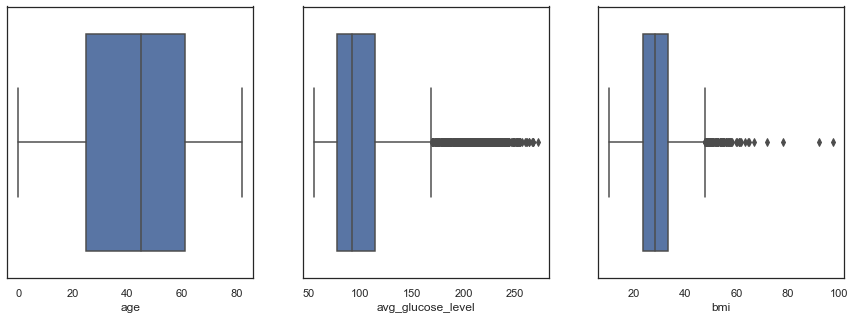

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes = axes.flat
for i, col in enumerate(cuantitative_columns):
    sns.boxplot(x = data[col], ax = axes[i])

## Correlación

In [42]:
corr_matrix = data[cuantitative_columns].corr(method='pearson')

In [43]:
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
0,bmi,age,0.333398,0.333398
1,avg_glucose_level,age,0.238171,0.238171
2,bmi,avg_glucose_level,0.175502,0.175502


In [44]:
tidy_corr_mat = tidy_corr_matrix(corr_matrix).head(10)
top_10_corr = set(tidy_corr_mat.variable_1.tolist() + tidy_corr_mat.variable_2.tolist())
corr_matrix_top10 = data[top_10_corr].corr(method='pearson')

<AxesSubplot:>

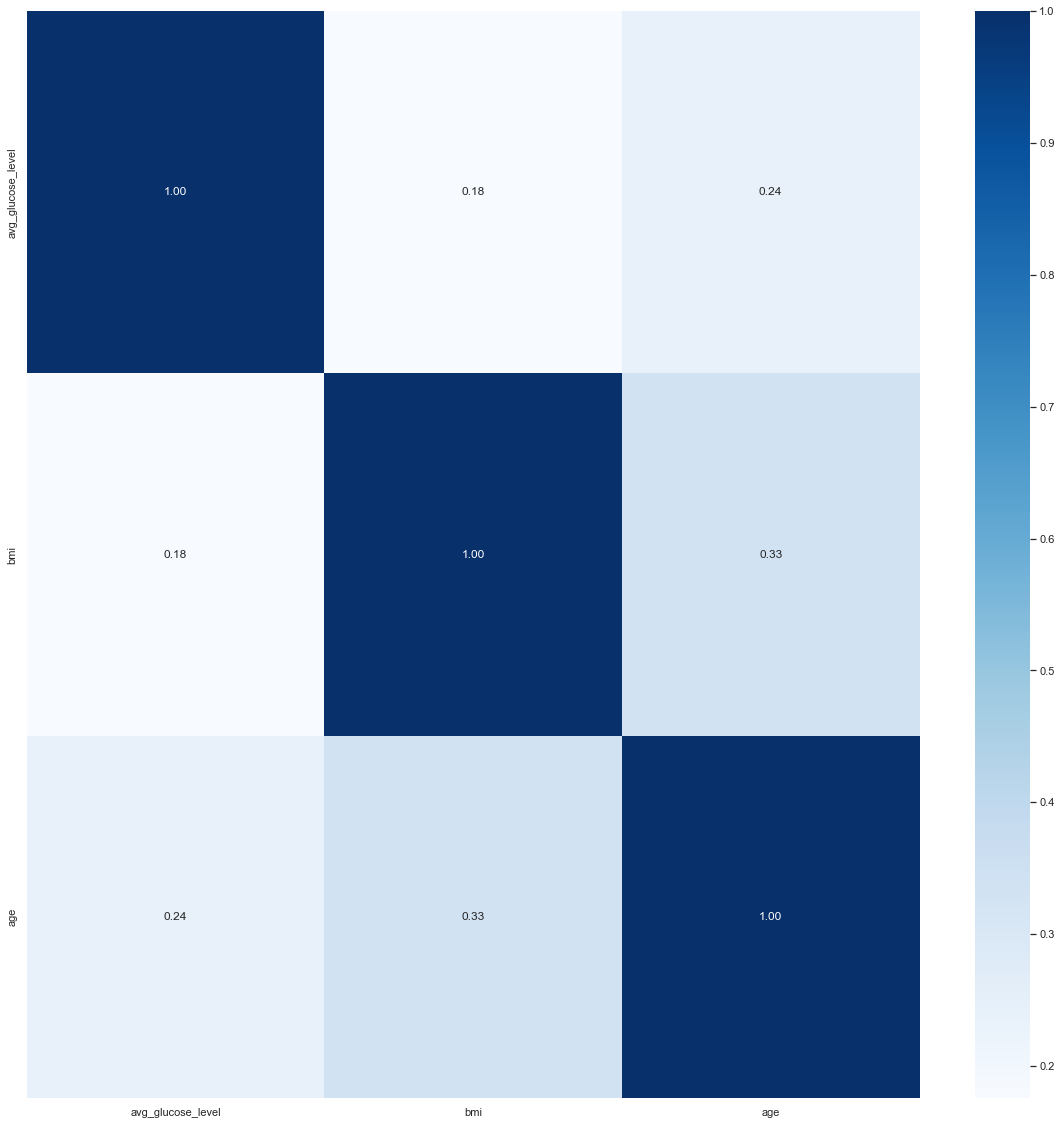

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20, 20))
sns.heatmap(corr_matrix_top10, fmt = '.2f', cmap = "Blues", annot = True)